In [1]:
#pd.set_option('display.max_rows', None)

In [2]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_V1 = pd.read_csv('df_V1.csv')
df_V2 = pd.read_csv('df_V2.csv')

# Data preprocessing - df with no null values
- Standardscaler
- PCA (explained variance 90%)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop the 'TARGET' column and store it separately
target_column = df_V2['TARGET']
df_V2 = df_V2.drop(columns=['TARGET'])

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_V2)

# Perform PCA on the scaled data
desired_variance_ratio = 0.90  
pca = PCA(n_components=desired_variance_ratio, svd_solver='full')  # Use svd_solver='full' for percentage explained variance
pca_result = pca.fit_transform(X_scaled)

# Calculate the actual explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Determine the number of components needed to achieve the desired variance
n_components = (cumulative_variance_ratio < desired_variance_ratio).sum() + 1

# Perform PCA again with the determined number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X_scaled)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the 'TARGET' column back to the PCA DataFrame
pca_df = pd.concat([pca_df, target_column], axis=1)

In [5]:
print("Dimensions dataset avant réduction PCA: ", df_V2.shape)
print("Dimensions dataset après réduction PCA: ", pca_df.shape)

Dimensions dataset avant réduction PCA:  (307488, 563)
Dimensions dataset après réduction PCA:  (307488, 298)


# Modeling

ROC AUC score is used as a performance metric to assess the model's ability to discriminate between classes on unseen data. It provides valuable information about the model's overall performance, especially in binary classification tasks.

In [6]:
from sklearn.model_selection import train_test_split

X = pca_df.drop(columns=['TARGET'])
y = pca_df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train.shape, X_test.shape

((206016, 297), (101472, 297))

## Proof of concept - DummyClassifier

In [10]:
import time
import pickle
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

In [11]:
from sklearn.dummy import DummyClassifier

# Define the parameter grid with different strategies
dummy_params = {'strategy': ['stratified', 'most_frequent', 'uniform']}

# Initialize an empty list to store cross-validation scores
accuracy_scores = []
roc_auc_scores = []

# Loop through the strategies and perform cross-validation for each
for strategy in dummy_params['strategy']:
    # Create a dummy classifier with the current strategy
    dummy_classifier = DummyClassifier(strategy=strategy, random_state=42)
    
    # Perform cross-validation for accuracy
    accuracy_scores_strategy = cross_val_score(dummy_classifier, X_train, y_train, cv=5, scoring='accuracy')
    
    # Perform cross-validation for ROC AUC
    roc_auc_scores_strategy = cross_val_score(dummy_classifier, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Calculate and store the mean scores for this strategy
    mean_accuracy_strategy = np.mean(accuracy_scores_strategy)
    mean_roc_auc_strategy = np.mean(roc_auc_scores_strategy)
    
    accuracy_scores.append(mean_accuracy_strategy)
    roc_auc_scores.append(mean_roc_auc_strategy)

# Print the mean scores for each strategy
for i, strategy in enumerate(dummy_params['strategy']):
    print(f"Strategy: {strategy}")
    print(f"Mean Accuracy: {accuracy_scores[i]:.3f}")
    print(f"Mean ROC AUC: {roc_auc_scores[i]:.3f}")
    print()

Strategy: stratified
Mean Accuracy: 0.851
Mean ROC AUC: 0.500

Strategy: most_frequent
Mean Accuracy: 0.919
Mean ROC AUC: 0.500

Strategy: uniform
Mean Accuracy: 0.500
Mean ROC AUC: 0.500



In [12]:
# Create and train a dummy classifier with "most_frequent" strategy
dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_classifier.fit(X_train, y_train)  

DummyClassifier(random_state=42, strategy='most_frequent')

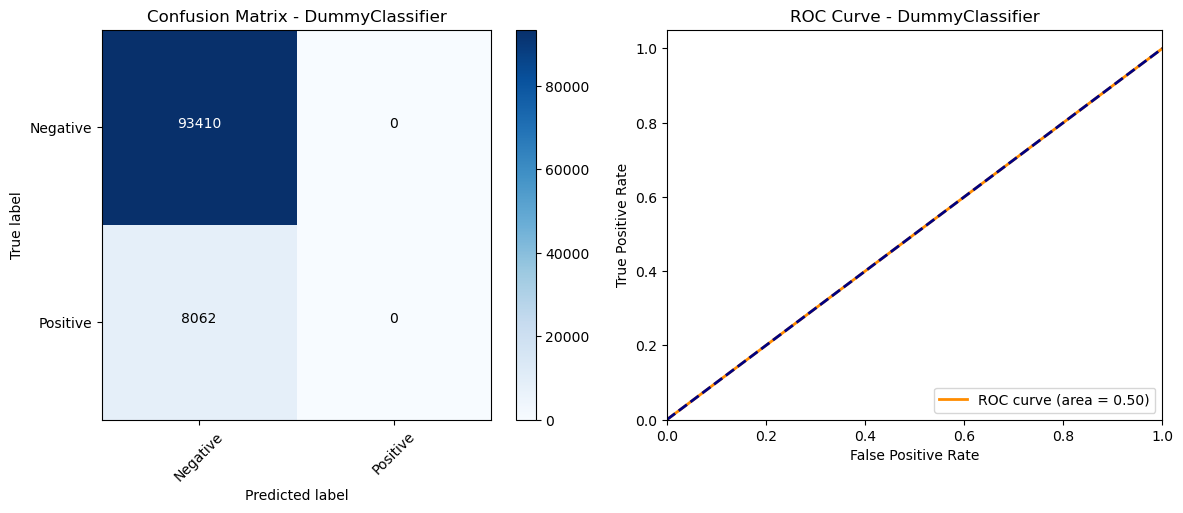

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
# Plot confusion matrix
y_pred = dummy_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=axes[0])
    
classes = ["Negative", "Positive"]
tick_marks = range(len(classes))
axes[0].set_xticks(tick_marks)
axes[0].set_xticklabels(classes, rotation=45)
axes[0].set_yticks(tick_marks)
axes[0].set_title(f'Confusion Matrix - DummyClassifier')
axes[0].set_yticklabels(classes)
    
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[0].text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
    
# Calculate and plot ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

    
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve - DummyClassifier')
axes[1].legend(loc="lower right")
    
plt.tight_layout()
plt.show()

## Different models

In [14]:
def grid_search_and_fit(model, param_grid, X_train, y_train, X_test, y_test, model_name):
    """
    Perform grid search to find the best hyperparameters for a model, train the best model, 
    and return the best score along with the training time in seconds.
    Also, perform cross-validation on the test set and return the test scores.

    Parameters:
    - model: The model to be trained and tuned.
    - param_grid: Dictionary with parameter names as keys and lists of parameter settings to try as values.
    - X_train: The training data features.
    - y_train: The training data target.
    - X_test: The test data features.
    - y_test: The test data target.
    - model_name: A unique name or identifier for the model.

    Returns:
    - best_score: The best cross-validated score on the training set.
    - best_params: The best hyperparameters.
    - training_time_seconds: The time taken to train the best model on the training set in seconds.
    - test_scores: Dictionary containing test scores (balanced_accuracy and ROC AUC) obtained from cross-validation on the test set.
    """
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    
    best_score = round(grid_search.best_score_, 3)
    best_params = grid_search.best_params_
    
    # Train the best model with the best hyperparameters on the training set
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    training_time_seconds = round(end_time - start_time)
    
    print(f"GridSearchCV results for {best_model}")
    print(f"\nBest ROC AUC score: {best_score:.3f}")
    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"Training time on Training Set (seconds): {training_time_seconds}")
    
    # Define custom scoring functions for cross-validation
    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': make_scorer(roc_auc_score)
    }
    
    # Perform cross-validation on the test set using StratifiedKFold for binary classification
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_scores = cross_validate(best_model, X_test, y_test, cv=cv, scoring=scoring)
    
    print("\nTest Scores:")
    print(f"Mean Accuracy: {test_scores['test_accuracy'].mean():.3f}")
    print(f"Std Accuracy: {test_scores['test_accuracy'].std():.3f}")
    print(f"Mean ROC AUC: {test_scores['test_roc_auc'].mean():.3f}")
    print(f"Std ROC AUC: {test_scores['test_roc_auc'].std():.3f}")

    # Save the trained model using pickle
    model_filename = f"{model_name}_model.pkl"  # Include the model name in the filename
    with open(model_filename, 'wb') as model_file:
        pickle.dump(best_model, model_file)
        
    print(f"\nModel saved: {model_filename}")

    # Extract and return the test scores
    return best_model, best_score, best_params, training_time_seconds, test_scores

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_evaluation_metrics(model, X_test, y_test, model_name):
    """
    Plot confusion matrix and ROC/AUC curve for a binary classification model.

    Parameters:
    - model: The trained classification model.
    - X_test: The test data features.
    - y_test: The test data target.
    - model_name: The name of the model for labeling the plots.

    Returns:
    - None (displays plots).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    plt.colorbar(im, ax=axes[0])
    
    classes = ["Negative", "Positive"]
    tick_marks = range(len(classes))
    axes[0].set_xticks(tick_marks)
    axes[0].set_xticklabels(classes, rotation=45)
    axes[0].set_yticks(tick_marks)
    axes[0].set_yticklabels(classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            axes[0].text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    axes[0].set_xlabel('Predicted label')
    axes[0].set_ylabel('True label')
    
    # Calculate ROC curve and AUC
    y_prob = model.predict_proba(X_test)[:, 1]  # predict_proba
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression 
logistic_regression = LogisticRegression(max_iter=650)
logistic_params = {'C': [0.01, 0.1, 1], 
                   'class_weight': ['balanced']}

GridSearchCV results for LogisticRegression(C=1, class_weight='balanced', max_iter=650)

Best ROC AUC score: 0.753
Best Parameters:
  C: 1
  class_weight: balanced
Training time on Training Set (seconds): 116

Test Scores:
Mean Accuracy: 0.688
Std Accuracy: 0.002
Mean ROC AUC: 0.680
Std ROC AUC: 0.006

Model saved: LogisticRegression_model.pkl


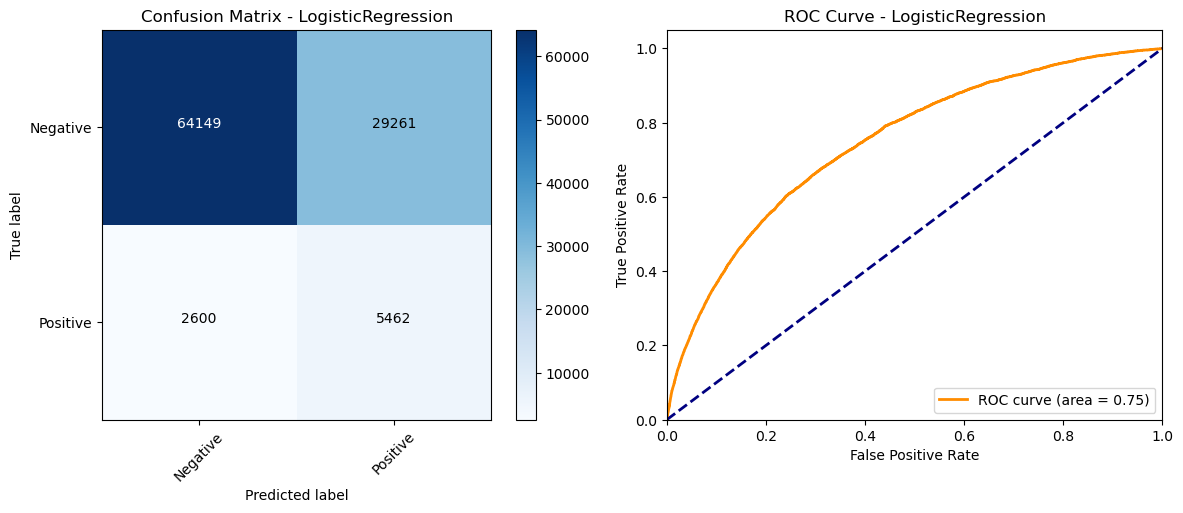

In [17]:
lr_best_model, lr_best_score, lr_best_params, lr_training_time_seconds, lr_test_scores = grid_search_and_fit(logistic_regression, logistic_params, X_train, y_train, X_test, y_test, model_name="LogisticRegression")
plot_evaluation_metrics(lr_best_model, X_test, y_test, "LogisticRegression")

### BayesianClassifier

In [18]:
from sklearn.naive_bayes import GaussianNB

BayesianClassifier = GaussianNB()
bayesian_params = {'var_smoothing': [1e-9, 1e-8, 1e-7],
                  'priors' : [None]}

GridSearchCV results for GaussianNB(var_smoothing=1e-07)

Best ROC AUC score: 0.623
Best Parameters:
  priors: None
  var_smoothing: 1e-07
Training time on Training Set (seconds): 18

Test Scores:
Mean Accuracy: 0.742
Std Accuracy: 0.105
Mean ROC AUC: 0.566
Std ROC AUC: 0.030

Model saved: BayesianClassifier_model.pkl


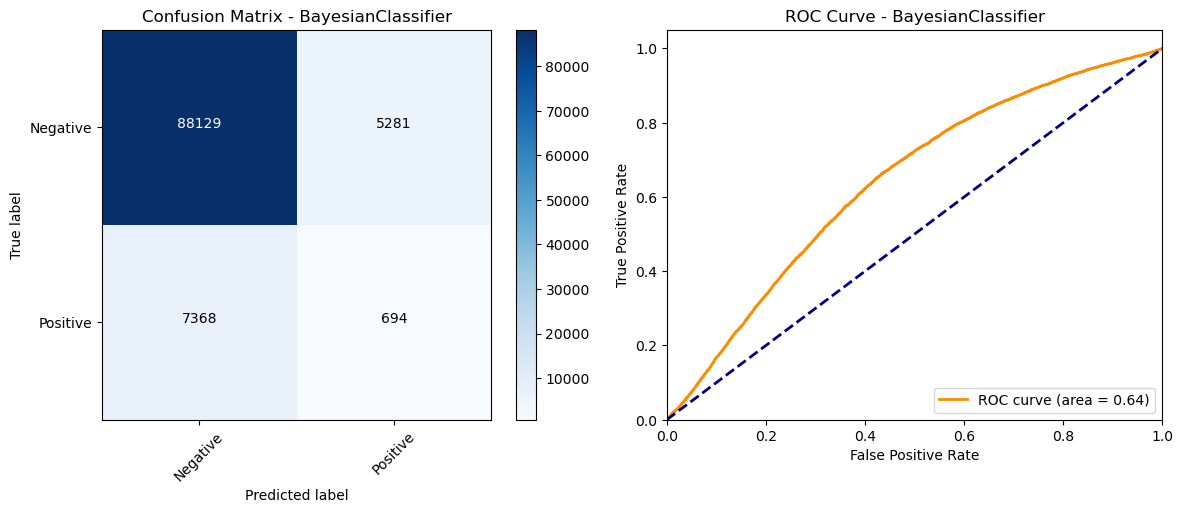

In [19]:
BC_best_model, BC_best_score, BC_best_params, BC_training_time_seconds, BC_test_scores = grid_search_and_fit(
    BayesianClassifier, bayesian_params, X_train, y_train, X_test, y_test, model_name="BayesianClassifier")
plot_evaluation_metrics(BC_best_model, X_test, y_test, "BayesianClassifier")

### LGBMClassifier

In [20]:
from lightgbm import LGBMClassifier
LGBMClassifier = LGBMClassifier(verbosity=-1) # verbosity = silent mode
LGBMC_params = {
    'boosting_type': ['dart'],     #'boosting_type': ['gbdt', 'dart', 'goss'],  # Different boosting types
    #'num_leaves': [20, 31, 40],   # Maximum number of leaves in one tree
    'learning_rate': [0.1],        #'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300],          #'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'class_weight': ['balanced'],  # Class weights (set to 'balanced' for imbalance handling)
}

In [21]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

GridSearchCV results for LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=300,
               verbosity=-1)

Best ROC AUC score: 0.738
Best Parameters:
  boosting_type: dart
  class_weight: balanced
  learning_rate: 0.1
  n_estimators: 300
Training time on Training Set (seconds): 309

Test Scores:
Mean Accuracy: 0.767
Std Accuracy: 0.003
Mean ROC AUC: 0.653
Std ROC AUC: 0.006

Model saved: LGBMClassifier_model.pkl


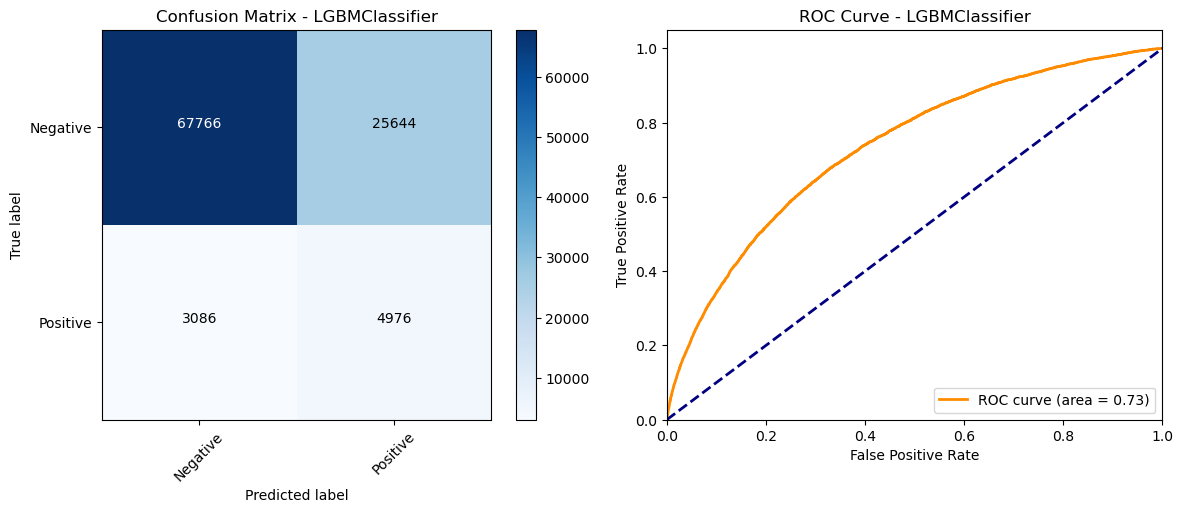

In [22]:
LGBM_best_model, LGBM_best_score, LGBM_best_params, LGBM_training_time_seconds, LGBM_test_scores = grid_search_and_fit(LGBMClassifier, LGBMC_params, X_train, y_train, X_test, y_test, model_name="LGBMClassifier")
plot_evaluation_metrics(LGBM_best_model, X_test, y_test, "LGBMClassifier")

### LGBMClassifier with nulls

In [23]:
import re

def clean_feature_name(feature_name):
    cleaned_name = re.sub(r'[^a-zA-Z0-9_]', '_', feature_name)
    return cleaned_name

# Apply clean_feature_name to all column names in df_V1
df_V1 = df_V1.rename(columns={col: clean_feature_name(col) for col in df_V1.columns})

In [24]:
X1 = df_V1.drop(columns=['TARGET'])
y1 = df_V1["TARGET"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)

GridSearchCV results for LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=300,
               verbosity=-1)

Best ROC AUC score: 0.777
Best Parameters:
  boosting_type: dart
  class_weight: balanced
  learning_rate: 0.1
  n_estimators: 300
Training time on Training Set (seconds): 303

Test Scores:
Mean Accuracy: 0.765
Std Accuracy: 0.002
Mean ROC AUC: 0.696
Std ROC AUC: 0.007

Model saved: LGBMClassifier_V2_model.pkl


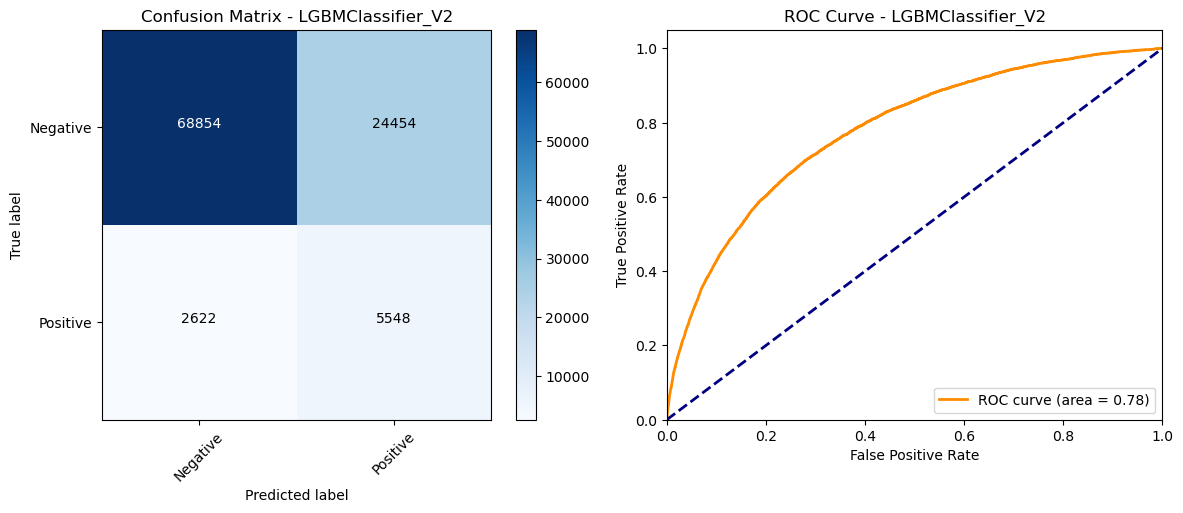

In [25]:
LGBM_best_model_V1, LGBM_best_score_V1, LGBM_best_params_V1, LGBM_training_time_seconds_V1, LGBM_test_scores_V1 = grid_search_and_fit(LGBMClassifier, LGBMC_params, X_train1, y_train1, X_test1, y_test1, model_name="LGBMClassifier_V2")
plot_evaluation_metrics(LGBM_best_model_V1, X_test1, y_test1, "LGBMClassifier_V2")